# Run classification splits

            JMA 24 Feb 2025

Just the first couple splits in a classification tree, to generate CPTs for 
an equivalent BN

In [1]:
# Imports from the python standard library
import math, re, os, sys 
from pathlib import Path
import itertools            # to flatten lists
from numpy.random import default_rng

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd
import torch

import rpy2.ipython

from scipy.stats import norm
import statsmodels.api as sm
import scipy as sp                   # for the Gaussian function
from scipy.cluster.vq import whiten  # For covariance matrix

# plots
import matplotlib.pyplot as plt
import seaborn as sns
# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, VBar, Span, Range1d, BoxAnnotation
from bokeh.io import output_notebook
from bokeh.transform import dodge
#

起動準備中です - 警告メッセージ:
sys.load.image(".RData", TRUE) で: non-uniform 'Rounding' sampler used


In [2]:
# Initialization
output_notebook()
rng = np.random.default_rng(seed=0)
torch.set_printoptions(profile='default')


Loading BokehJS ...

## Simulate some continuous data

In [ ]:
# Observations

obs_labels = ('ig_fault', 'carb_fault', 'door_fault')
# The means could be the priors on the splits
ig_mean = 1.0
carb_mean = door_mean = 2.0
ig_sd = carb_sd = door_sd = 0.25


# split1 = 2.0
# split2 = -1.0

 # Create some random partitions
CNTS = 1000

## Bernoulli success rates for the observations.    P( y | obs )
p_ig = 0.4
p_carb = 0.75

# prob of the exclusive or  = p(or) - p(and)
f'{p_ig + p_carb - 2 * (p_ig * p_carb):.3f}' 

'0.550'

In [4]:
# In pytorch
# def partition_further(z):
#     return (rng.binomial(n=1, p=p2) if z == 1 else 0)

# Two logical variables, to create different combinations of x1, x2
a_partition = torch.bernoulli(p_ig * torch.ones((1,CNTS)))
b_partition = torch.bernoulli(p_carb * torch.ones((1,CNTS)))
ys = torch.vstack((a_partition,  b_partition))
y = ys.sum(axis=0)
print(ys[:,0:20])


tensor([[1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
         0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 1.]])


In [5]:
# Reduce the y array binary 0, 1s, exclusive or. 
y_or =y.clone().apply_(lambda z: 1 if z> 0 else 0 )
y_xor = torch.add(ys[0,:], ys[1,:])  - 2 * torch.mul(ys[0,:], ys[1,:])
y_xor[:20]

tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1.])

In [6]:
# Create noisy versions of each binary var

def noisy_partition(partition, m, s, spread=1):
    return torch.normal(m * (spread + partition), s)

x1 = noisy_partition(ys[0,:],ig_mean, ig_sd)
x2 = noisy_partition(ys[1,:],carb_mean, carb_sd)

p_df = pd.DataFrame({"y": y_xor, obs_labels[0]:x1, obs_labels[1]:x2})
p_var = p_df.columns

In [7]:
# Add an irrelevant continuous variable
x3 = noisy_partition(torch.ones(CNTS),door_mean, door_sd)
p_df = p_df.assign(**{obs_labels[2]: x3})

# Build the covariance matrix of the whitened df
p_cov = torch.cov(torch.tensor(whiten(p_df.values).T))
p_var = p_var.append(pd.Index([obs_labels[2]]))


### feature correlation matrix

Two features, ig_fault and carb_fault are weakly correlated to the outcome, and door_fault is not correlated at all.

In [8]:
pd.options.display.float_format = '{:.3f}'.format
print(pd.DataFrame(p_cov, index=p_var, columns=p_var))

                y  ig_fault  carb_fault  door_fault
y           1.001    -0.428       0.124       0.037
ig_fault   -0.428     1.001      -0.003      -0.028
carb_fault  0.124    -0.003       1.001      -0.050
door_fault  0.037    -0.028      -0.050       1.001


In [9]:
# Look at the data
p_df.head()

,y,ig_fault,carb_fault,door_fault
0,0.000,2.214,4.169,4.081
1,0.000,2.031,4.122,4.093
2,1.000,1.734,2.247,4.499
3,1.000,1.366,3.558,3.826
4,0.000,1.773,3.708,3.920


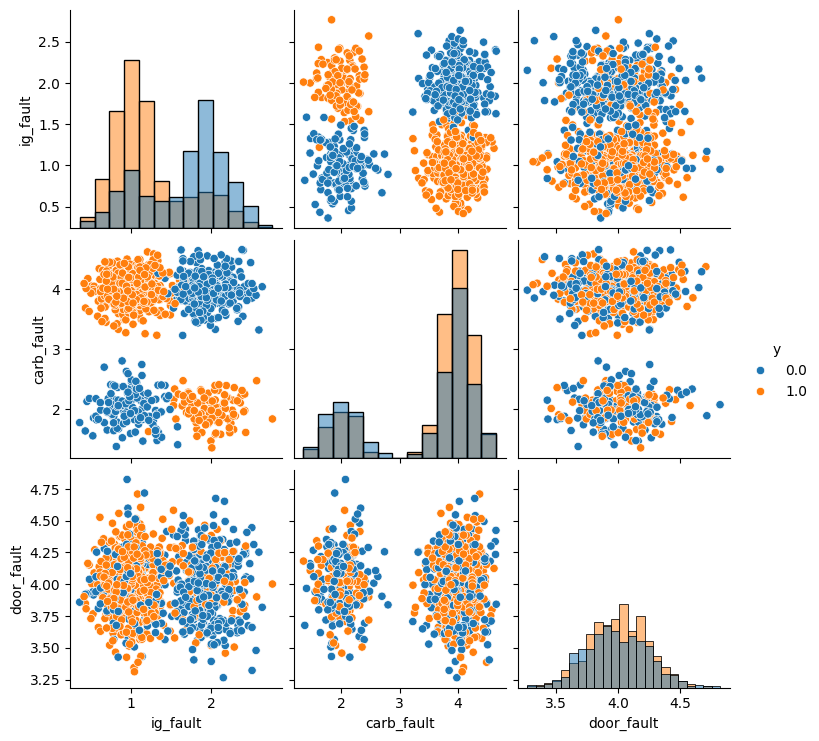

In [10]:
sns.pairplot(p_df, diag_kind='hist', hue = 'y')

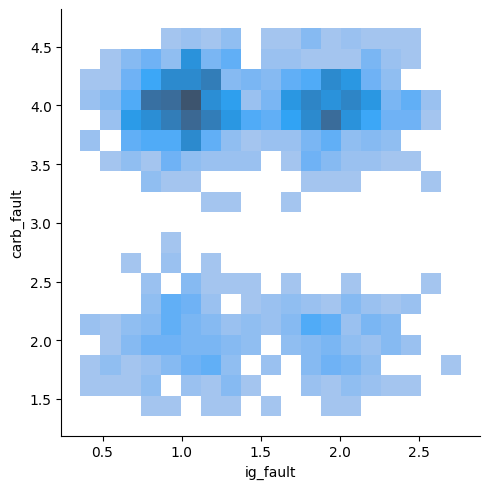

In [11]:
sns.displot(p_df, x= 'ig_fault', y= 'carb_fault', bins = 19)

### What does a entirely random prediction look like?

Run an ols with just the random variable

The residuals plot shows perfect separation of classes. Residuals should show the noise component, so no pattern among the residuals should be apparent. The regression has not explained any of the variance in $y$.

Text(0, 0.5, 'Residual')

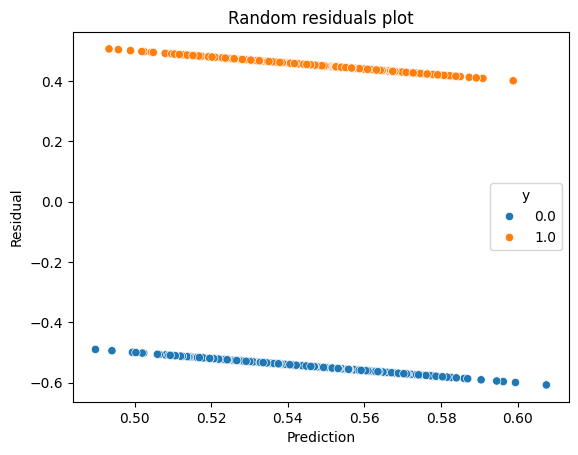

In [12]:
X = p_df[['door_fault']]
y = p_df[['y']]
X = X.assign(c=pd.DataFrame(np.ones(len(y))))

rand_model = sm.OLS(y,X)
sns.scatterplot(x=rand_model.fit().predict(), y=rand_model.fit().resid, hue = p_df['y'])
plt.title("Random residuals plot")
plt.xlabel('Prediction')
plt.ylabel('Residual')

### OLS predictor from the 3 features

Because the prediction is not linearly separable in the features, the quality of the linear predictor is low. 

In [13]:
X = p_df[list(obs_labels)]
y = p_df[['y']]
X = X.assign(c=pd.DataFrame(np.ones(len(y))))

model = sm.OLS(y,X)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     82.55
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.07e-47
Time:                        15:50:20   Log-Likelihood:                -610.70
No. Observations:                1000   AIC:                             1229.
Df Residuals:                     996   BIC:                             1249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ig_fault      -0.3966      0.026    -15.041      0.000      -0.448      -0.345
carb_fault     0.0690      0.016      4.380      0.000       0.038       0.100
door_fault     0.0639      0.058      1.094      0.274      -0.051       0.179
c              0.6118      0.247      2.478      0.013       0.127       1.096
==============================================================================
Omnibus:                      204.818   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.219
Skew:                           0.145   Prob(JB):                     2.50e-10
Kurtosis:                       2.011   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### These plots of residuals show that no individual feature strongly distinguishes y

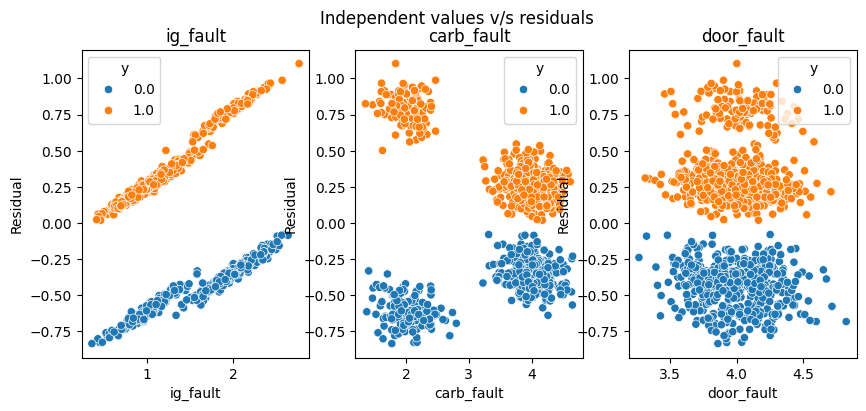

In [14]:
# Residuals plot
sample_residuals = model.fit().resid
g = plt.figure(figsize=(10,4))
plt.suptitle('Independent values v/s residuals')
plt.subplot(1, 3, 1)
sns.scatterplot(x='ig_fault', y=sample_residuals, data=p_df, hue = y.squeeze())
plt.ylabel('Residual')
plt.title('ig_fault')
plt.subplot(1, 3, 2)
sns.scatterplot(x='carb_fault', y=sample_residuals, data= p_df, hue = y.squeeze())
plt.ylabel('Residual')
plt.title('carb_fault')
plt.subplot(1, 3, 3)
sns.scatterplot(x='door_fault', y=sample_residuals, data= p_df, hue = y.squeeze())
plt.ylabel('Residual')
plt.title('door_fault')
plt.show()


### Predictions versus independent variables. 

The more accurate the prediction, the more clearly the two classes should be distinguished, by falling either above or below the threshold line. 

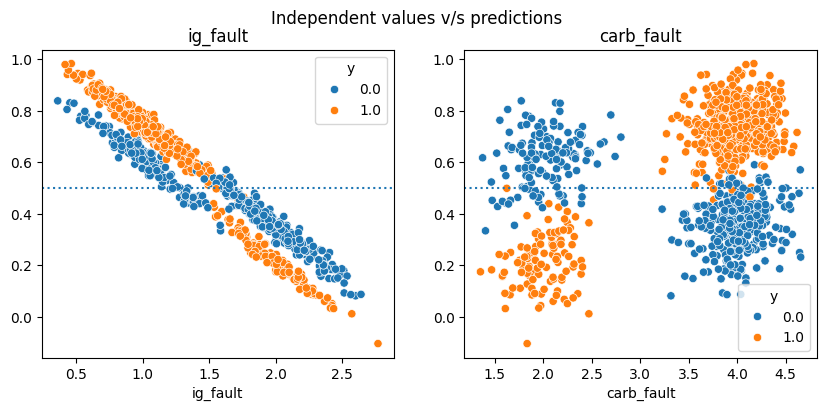

In [15]:
model_predictions = model.fit().predict()
g = plt.figure(figsize=(10,4))
plt.suptitle('Independent values v/s predictions')
plt.subplot(1, 2, 1)
sns.scatterplot(x=x1, y=model_predictions, hue = y.squeeze())
plt.axhline(y = 0.5,  linestyle = ':') 
plt.xlabel('ig_fault')
plt.title('ig_fault')
plt.subplot(1, 2, 2)
sns.scatterplot(x=x2, y=model_predictions, hue = y.squeeze())
plt.axhline(y = 0.5,  linestyle = ':') 
plt.xlabel('carb_fault')
plt.title('carb_fault')
plt.show()

Text(0, 0.5, 'Residual')

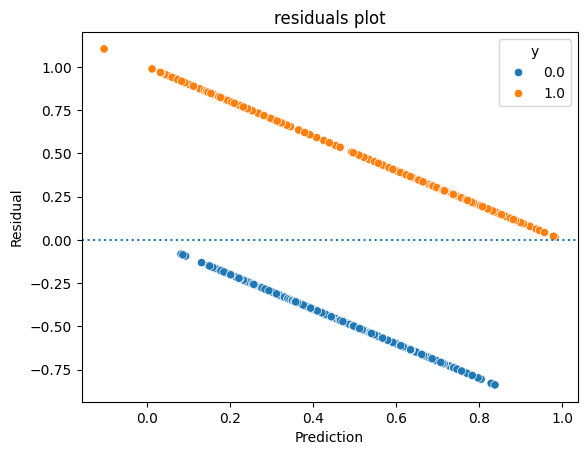

In [16]:
sns.scatterplot(x=model_predictions, y=sample_residuals, hue = p_df['y'])
plt.title("residuals plot")
plt.axhline(y = 0.0,  linestyle = ':') 
plt.xlabel('Prediction')
plt.ylabel('Residual')

accuracy =  0.749


<Axes: >

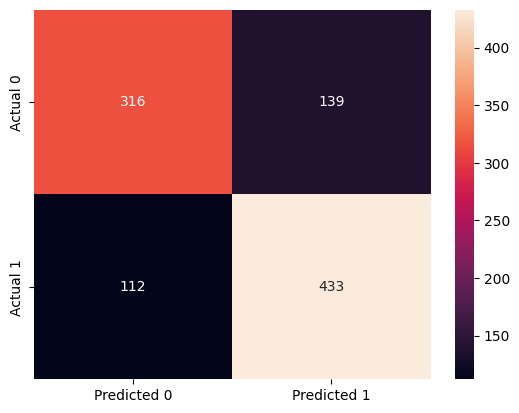

In [17]:
# Create confusion matrix 
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true = y_xor, y_pred=(model_predictions > 0.5))
cm_df = pd.DataFrame(confusion, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
accuracy = (confusion[0,0] + confusion[1,1])/confusion.sum()
print('accuracy = ', accuracy)
sns.heatmap(cm_df, annot=True, fmt = 'd')

In [18]:
# Save the model training data
p_df['y'] = p_df['y'].astype('bool')
p_df.to_csv('/Users/jma/Documents/BayesFusion/simulated_states.csv', header=True, index=None)

In [63]:
# Convert variables to R friendly form
obs_labels_list = list(obs_labels)

## Run a Classification Tree model using `R` rpart

The classification tree can accommodate the non-linearities in the classification rule, and give almost complete classification from the existing features.

In [19]:
%load_ext rpy2.ipython


In [211]:
%%R
options(width = 200)
R.version.string

[1] "R version 4.4.3 (2025-02-28)"


In [21]:
%%R 
#  -i cm_df
require(rpart)
paste("Is the rpart library loaded: " , any("rpart" == library()$results[,1]))


[1] "Is the rpart library loaded:  TRUE"


要求されたパッケージ rpart をロード中です


In [22]:
%%R -i p_df
# Reference the data in python, to use as an R dataframe
str(p_df)

'data.frame':	1000 obs. of  4 variables:
 $ y         : logi  FALSE FALSE TRUE TRUE FALSE TRUE ...
 $ ig_fault  : num  2.21 2.03 1.73 1.37 1.77 ...
 $ carb_fault: num  4.17 4.12 2.25 3.56 3.71 ...
 $ door_fault: num  4.08 4.09 4.5 3.83 3.92 ...


In [67]:
%%R 
# Create the model
classification_tree <- rpart(y ~ ., data = p_df, method="class")
print(summary(classification_tree))

Call:
rpart(formula = y ~ ., data = p_df, method = "class")
  n= 1000 



         CP nsplit  rel error     xerror        xstd
1 0.4329670      0 1.00000000 1.00000000 0.034609279
2 0.3010989      1 0.56703297 0.57142857 0.030485347
3 0.2219780      2 0.26593407 0.26813187 0.022746563
4 0.0100000      3 0.04395604 0.04395604 0.009730085

Variable importance
carb_fault   ig_fault door_fault 
        75         25          1 

Node number 1: 1000 observations,    complexity param=0.432967
  predicted class=TRUE   expected loss=0.455  P(node) =1
    class counts:   455   545
   probabilities: 0.455 0.545 
  left son=2 (415 obs) right son=3 (585 obs)
  Primary splits:
      ig_fault   < 1.56532   to the right, improve=113.108700, (0 missing)
      carb_fault < 3.227275  to the left,  improve=  9.451384, (0 missing)
      door_fault < 3.757347  to the left,  improve=  3.923901, (0 missing)
  Surrogate splits:
      carb_fault < 4.435948  to the right, agree=0.594, adj=0.022, (0 split)
      door_fault < 3.333539  to the left,  agree=0.586, adj=0.002, (0 split)


In [ ]:
%%R
require(dplyr)
# rpart's "where" component tells where each sample winds up:
print(paste("Leaf: ", unique(classification_tree$where)))
# We'll use the leaf nodes to derive the predictive probabilities for the influence diagram model. 
# TODO match the leaf node numbers with the rows.  
leaf_nodes <- classification_tree$frame %>% filter( var == '<leaf>')
print(leaf_nodes)

[1] "Leaf:  3" "Leaf:  4" "Leaf:  7" "Leaf:  6"
     var   n  wt dev yval  complexity ncompete nsurrogate     yval2.V1
1 <leaf> 310 310   6    1 0.000000000        0          0   1.00000000
2 <leaf> 105 105   2    2 0.010000000        0          0   2.00000000
3 <leaf> 147 147   5    1 0.002197802        0          0   1.00000000
4 <leaf> 438 438   7    2 0.000000000        0          0   2.00000000
      yval2.V2     yval2.V3     yval2.V4     yval2.V5 yval2.nodeprob
1 304.00000000   6.00000000   0.98064516   0.01935484     0.31000000
2   2.00000000 103.00000000   0.01904762   0.98095238     0.10500000
3 142.00000000   5.00000000   0.96598639   0.03401361     0.14700000
4   7.00000000 431.00000000   0.01598174   0.98401826     0.43800000


In [40]:
%%R
tree_df <- classification_tree$frame
print(attributes(tree_df))
row.names(tree_df)

$names
[1] "var"        "n"          "wt"         "dev"        "yval"      
[6] "complexity" "ncompete"   "nsurrogate" "yval2"     

$row.names
[1] 1 2 4 5 3 6 7

$class
[1] "data.frame"

[1] "1" "2" "4" "5" "3" "6" "7"


In [43]:
%%R
# Associated row names for the data.frame rows
row.names(tree_df)[unique(classification_tree$where)]

[1] "4" "5" "7" "6"


In [ ]:
%%R
# Find the correspondence of rules to the frame rownames
# NOte the difference from the previous cell. 
# See https://www.r-bloggers.com/2022/10/understanding-leaf-node-numbers-when-using-rpart-and-rpart-rules/

row.names(rules)

[1] "4" "6" "5" "7"


In [212]:
%%R -i obs_labels_list -o cpt_df
build.cpt <- function(c_tree, i1= 4, i2=8) {
    # I1, i2 are the columns containing the connectives '<" and '>="
    rules <- rpart.rules(c_tree)
    # TODO verify this node name assignment
    rules[["node"]] <- row.names(rules) # row.names(tree_df)[unique(classification_tree$where)]
    print(rules)
    # Use the rules features to create a cpt for P( y | features )
    # order the features. 
    # features <- obs
   

    # For now assume one leaf node per CPT element, and binary y and features. 
    # Find all features used in splits. 
    obs <- unique(c(rules[[i1-1 ]] , rules[[i2-1]])) # relevant_features
    cat( obs[1], obs[[2]], '\n')
    ar_names = list(c("TRUE", "FALSE"),c("TRUE", "FALSE"),c("TRUE", "FALSE"))# list(rep(c("TRUE", "FALSE"), 1+length(relevant_features)))
    CPT = array(NA, dim=c(2,2,2), dimnames=ar_names)
    # mappings from rule labels to matrix entries
    m = list(">=" = "TRUE", "< "="FALSE")
    for (irow in 1:nrow(rules)) {
        v1 <- rules[[irow, i1]]
        v2 <- rules[[irow, i2]]
        cat(v1,v2, '\n')   # check the connectives
        # cat(as.numeric(rules[["node"]][irow]), m[[v1]],m[[v2]], '\n')
        p <- as.numeric(rules[[irow, "y"]])
        # cat( m[[v1]], '\n', m[[v2]], '\n' )
        CPT[  "TRUE", m[[v1]], m[[v2]]] <- p 
        CPT["FALSE", m[[v1]], m[[v2]]] <- 1 - p
    }
    ar_names <- list(c("TRUE", "FALSE"),
        c(obs[1], paste0("not_",obs[1])),
        c(obs[2], paste0("not_",obs[2])))

    dimnames(CPT) <- ar_names
    CPT
}

CPT <- build.cpt(classification_tree)

cpt_df <- data.frame(CPT)
cpt_df

    y            .1 .2  .3 .4         .5 .6  .7 node
 0.02 when ig_fault >= 1.6  & carb_fault >= 2.8    4
 0.03 when ig_fault <  1.6  & carb_fault <  3.0    6
 0.98 when ig_fault >= 1.6  & carb_fault <  2.8    5
 0.98 when ig_fault <  1.6  & carb_fault >= 3.0    7
ig_fault carb_fault 
>= >= 
<  <  
>= <  
<  >= 
      ig_fault.carb_fault not_ig_fault.carb_fault ig_fault.not_carb_fault not_ig_fault.not_carb_fault
TRUE                 0.02                    0.98                    0.98                        0.03
FALSE                0.98                    0.02                    0.02                        0.97


In [167]:
%%R
# str(rules)
z = list(">=" = "TRUE", "<"="FALSE")
# 
obs <- obs_labels_list
c(obs[1], paste0("not_",obs[1]))
# z[[1]]

[1] "ig_fault"     "not_ig_fault"


In [25]:
%%R
classification_tree$splits

           count ncat     improve     index         adj
ig_fault    1000    1 113.1086860 1.5653197 0.000000000
carb_fault  1000   -1   9.4513837 3.2272749 0.000000000
door_fault  1000   -1   3.9239011 3.7573473 0.000000000
carb_fault     0    1   0.5940000 4.4359481 0.021686747
door_fault     0   -1   0.5860000 3.3335390 0.002409639
carb_fault   415    1 145.0506172 2.8487781 0.000000000
door_fault   415   -1   3.4244647 3.7839042 0.000000000
ig_fault     415   -1   1.1254611 1.5915790 0.000000000
carb_fault   585   -1 198.6630256 3.0149207 0.000000000
ig_fault     585    1   2.3764357 1.3047149 0.000000000
door_fault   585    1   0.9760950 4.5395415 0.000000000
door_fault     0    1   0.7521368 4.5395415 0.013605442
ig_fault       0   -1   0.7504274 0.4313022 0.006802721


In [26]:
%%R
classification_tree$variable.importance
# Note that importance is calculated as the sum over the node improvements for that variable. 

carb_fault   ig_fault door_fault 
346.166602 114.460135   2.975449 


要求されたパッケージ rpart.plot をロード中です


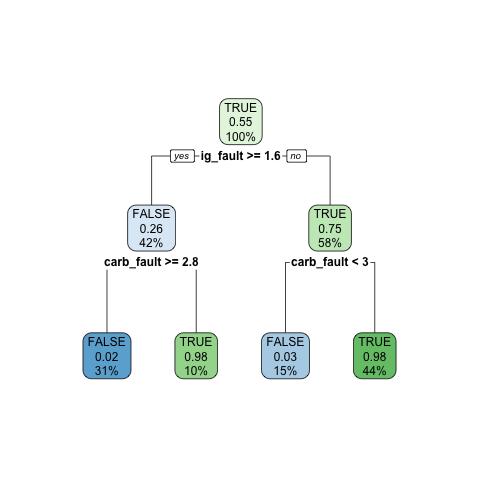

In [27]:
%%R
require(rpart.plot)
rpart.plot(classification_tree)

In [193]:
# Are the dimension labels lost from R? 
# And the dimension orders swapped. 
print(cpt_df)

       ig_fault.carb_fault  not_ig_fault.carb_fault  ig_fault.not_carb_fault  \
TRUE                 0.020                    0.980                    0.980   
FALSE                0.980                    0.020                    0.020   

       not_ig_fault.not_carb_fault  
TRUE                         0.030  
FALSE                        0.970  


# Build the CPT from the leaf nodes. 

### Re-run the classification tree with prior P( lemon ) = 0.2

This demonstrates that rpart can incorporate a prior to re-weight the input data. How does one add priors?  "...the effect of priors is identical to that of adding case weights to the observations such that the apparent frequencies are equal to the chosen priors; (logintro.pdf)"

However the documentation explains the use of the `params` argument:

    "For classification splitting, the list can contain any of: the vector of prior probabilities (component prior), the loss matrix (component loss) or the splitting index (component split). The priors must be positive and sum to 1. The loss matrix must have zeros on the diagonal and positive off-diagonal elements. The splitting index can be gini or information. The default priors are proportional to the data counts, the losses default to 1, and the split defaults to gini.

In [178]:
%%R
p_lemon = 0.2
tree_w_prior <- rpart(y ~ ., data = p_df, method="class", parms = list(prior = c(p_lemon, 1 - p_lemon)))
print(summary(tree_w_prior))

Call:
rpart(formula = y ~ ., data = p_df, method = "class", parms = list(prior = c(p_lemon, 
    1 - p_lemon)))
  n= 1000 

          CP nsplit  rel error     xerror       xstd
1 0.31204759      0 1.00000000 1.00000000 0.03460928
2 0.27539066      2 0.37590483 0.37590483 0.03018743
3 0.02276439      3 0.10051416 0.09317472 0.02394716
4 0.01000000      4 0.07774977 0.10196592 0.02431198

Variable importance
carb_fault   ig_fault door_fault 
        78         22          1 

Node number 1: 1000 observations,    complexity param=0.3120476
  predicted class=TRUE   expected loss=0.2  P(node) =1
    class counts:   455   545
   probabilities: 0.200 0.800 
  left son=2 (415 obs) right son=3 (585 obs)
  Primary splits:
      ig_fault   < 1.56532   to the right, improve=55.02209, (0 missing)
      carb_fault < 3.227275  to the left,  improve= 4.30183, (0 missing)
      door_fault < 3.725072  to the left,  improve= 1.79674, (0 missing)
  Surrogate splits:
      carb_fault < 4.435948  to the rig

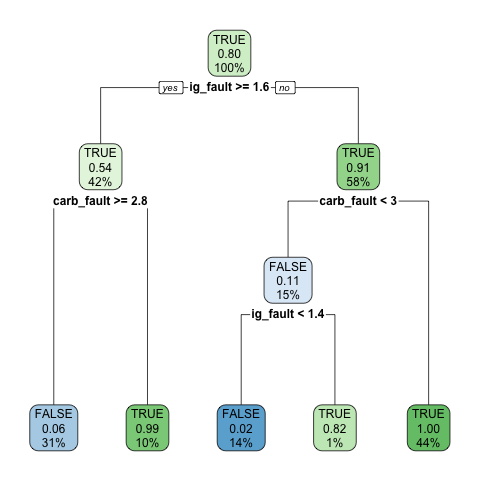

In [179]:
%%R
rpart.plot(tree_w_prior)

### (misc)

In [213]:
%%R
options(width = 200)
pCPT <- build.cpt(tree_w_prior, i1=4, i2=10)

pCPT

    y            .1 .2  .3 .4  .5 .6         .7 .8  .9 node
 0.02 when ig_fault <  1.4         & carb_fault <  3.0   12
 0.06 when ig_fault >=        1.6  & carb_fault >= 2.8    4
 0.82 when ig_fault is 1.4 to 1.6  & carb_fault <  3.0   13
 0.99 when ig_fault >=        1.6  & carb_fault <  2.8    5
 1.00 when ig_fault <  1.6         & carb_fault >= 3.0    7
ig_fault carb_fault 
<  <  
>= >= 
is <  
>= <  
<  >= 
, , carb_fault

      ig_fault not_ig_fault
TRUE      0.06            1
FALSE     0.94            0

, , not_carb_fault

      ig_fault not_ig_fault
TRUE      0.99         0.02
FALSE     0.01         0.98



/var/folders/x3/t7qpngm57q96p9wxzg9rqv6h0000gp/T/ipykernel_79219/828297661.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(x > split).to(torch.int32)
/var/folders/x3/t7qpngm57q96p9wxzg9rqv6h0000gp/T/ipykernel_79219/828297661.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_gt_split = (x.clone() + norm.rvs(m, s,CNTS)) * (y -1)
/var/folders/x3/t7qpngm57q96p9wxzg9rqv6h0000gp/T/ipykernel_79219/828297661.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_lt_split = (x.clone() + norm.rvs( m, s,CNTS)) * (1 - y)


NameError: name 'unsplit_x_gt' is not defined

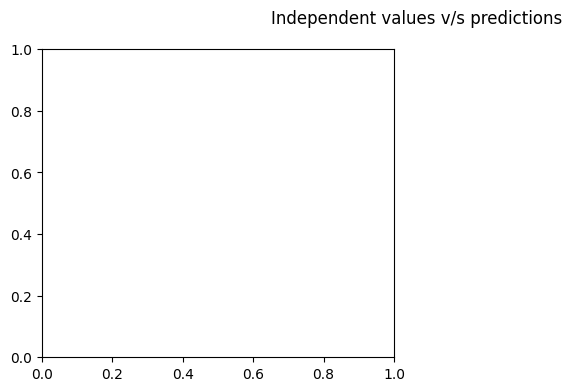

In [32]:
def x2_split(x: np.ndarray, split: float, m = ig_mean, s = ig_sd):
    '''Input - a random vector x
    Output - a noisy split around split'''
    # The split is implicitly the prior, unobserved state. 
    y = torch.tensor(x > split).to(torch.int32)  
    # The larger split
    x_gt_split = (x.clone() + norm.rvs(m, s,CNTS)) * (y -1)
    # The smaller split
    x_lt_split = (x.clone() + norm.rvs( m, s,CNTS)) * (1 - y)
    return x_gt_split,  x_lt_split, y

# x1 = norm.rvs(x1_mean, x1_sd, CNTS)

### First split
x_gt_split,  x_lt_split, y = x2_split(x1, 1)
# unsplit_x_gt = (x * x_prior)[x_prior]
# unsplit_x_lt = (x * (1-x_prior))[np.bool(1-x_prior)]

g = plt.figure(figsize=(10,4))
plt.suptitle('Independent values v/s predictions')
plt.subplot(1, 2, 1)
sns.histplot(unsplit_x_gt)
plt.subplot(1, 2, 2)
sns.histplot(unsplit_x_lt)
plt.show()



<Axes: ylabel='Count'>

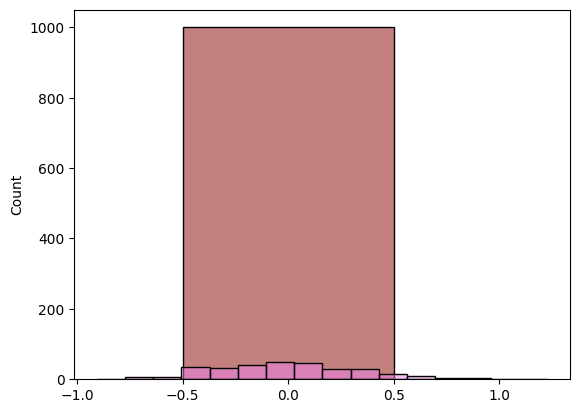

In [ ]:
### Second split

sns.histplot(unsplit_x_gt, color = 'darkred', alpha= 0.5)
sns.histplot(unsplit_x_lt, color = 'violet', alpha= 0.5)